In [68]:
import requests
import json

#import googlemaps
from itertools import tee

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

%matplotlib inline
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.patches import Rectangle
import math
import re
import os
from requests import get
from urllib.parse import urlparse
import io

from scipy import stats

from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar

from sklearn.metrics.pairwise import haversine_distances

import networkx as nx

# Load Data

In [69]:
London = gpd.read_file('./data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
#commute_time=pd.read_csv('./data/travel_time_usual.csv')
#commute_time_strike=pd.read_csv('./data/travel_time_without_metro_2011.csv')
#commute_time_strike=pd.read_csv('./data/travel_time_tube_strike.csv')
#commute_time_strike_tram=pd.read_csv('./data/travel_time_rail_strike.csv')
commute_time=pd.read_csv('./data/travel_time/usual_travel_time.csv')
commute_time_strike=pd.read_csv('./data/travel_time/tube_strike_travel_time.csv')
commute_time_strike_tram=pd.read_csv('./data/travel_time/tram_strike_travel_time.csv')
lines = gpd.read_file('data/tfl_lines.json')

In [70]:
commuter_age=pd.read_csv('./data/WU02UK_msoa_v2/wu02uk_msoa_v2.csv', 
                         names=['Area of residence', 'Area of workplace','All categories: Age 16 and over',
                               '16-24', '25-34', '35-49', '50-64', '65-74', '75+'])

commuter_industry=pd.read_csv('./data/WU06BUK_msoa_v1/wu06buk_msoa_v1.csv',
                             names=['Area of usual residence', 'Area of workplace', 'All categories: Industry',
                                   'Agriculture, forestry and fishing', 'Mining  and quarrying', 'Manufacturing',
                                   'Electricity, gas, steam and air conditioning supply', 'Water supply; sewerage, waste management and remediation activities',
                                   'Construction', 'Wholesale and retail trade; repair of motor vehicles and motorcycles',
                                   'Transport and storage', 'Accommodation and food service activities', 'Information and communication',
                                   'Financial and insurance activities', 'Real estate activities', 'Professional, scientific and technical activities',
                                   'Administrative and support service activities', 'Public administration and defence; compulsory social security',
                                   'Education', 'Human health and social work activities', 'Arts, entertainment and recreation',
                                   'Other service activities', 'Activities of household as employers; undifferentiated goods - and services - producing activities of households for own use',
                                   'Activities of extraterritorial organisations and bodies'])

commuter_occupation=pd.read_csv('./data/WU07AUK_msoa_v1/wu07auk_msoa_v1.csv', 
                                names=['Area of usual residence', 'Area of workplace', 'All categories: Occupation',
                                      'Managers, directors and senior officials', 'Professional occupations', 'Associate professional and technical occupations',
                                      'Administrative and secretarial occupations', 'Skilled trades occupations', 'Caring, leisure and other service occupations',
                                      'Sales and customer service occupations', 'Process, plant and machine operatives', 'Elementary occupations'])

# Pre-process Data

In [71]:
London_MSOA_cent=London.copy()
London=London.to_crs(epsg=4326)
London_MSOA=London.loc[:,['MSOA11CD', 'MSOA11NM']]
London_MSOA_list=list(London_MSOA['MSOA11CD'])
London['centre']=London.to_crs('+proj=cea').centroid.to_crs(epsg=4326)
London['centre_lat'] = London.centre.apply(lambda p: p.y)
London['centre_lon'] = London.centre.apply(lambda p: p.x)
London.head()

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,centre,centre_lat,centre_lon
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.50,4385,1.60,"MULTIPOLYGON (((-0.10414 51.50841, -0.10444 51...",POINT (-0.09213 51.51482),51.51,-0.09
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.30,2713,2.50,"POLYGON ((0.14809 51.59678, 0.14806 51.59640, ...",POINT (0.13947 51.58827),51.59,0.14
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.90,3834,2.60,"POLYGON ((0.15063 51.58306, 0.14838 51.58075, ...",POINT (0.14090 51.57492),51.57,0.14
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.80,2318,2.60,"POLYGON ((0.18508 51.56480, 0.18400 51.56391, ...",POINT (0.17683 51.55548),51.56,0.18
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.10,3183,2.70,"POLYGON ((0.14988 51.56807, 0.15076 51.56778, ...",POINT (0.14332 51.56142),51.56,0.14


In [72]:
lines['mode']=lines['lines']
for i in range(0, lines.shape[0]):
    lines_dict=json.loads(lines.iloc[i,1])
    lines.loc[i,'mode']=lines_dict[0]['name']
    
lines.head()

,id,lines,geometry,mode
0,LeaValleyLine1,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.05941 51.52391, -0.05910 51.523...",London Overground
1,LeaValleyLine2,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.05760 51.53245, -0.05767 51.532...",London Overground
2,LeaValleyLine3,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.05785 51.54118, -0.05780 51.541...",London Overground
3,LeaValleyLine4,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.06116 51.54909, -0.06122 51.549...",London Overground
4,LeaValleyLine5,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (-0.06845 51.55866, -0.06868 51.559...",London Overground


In [73]:
tube=['Bakerloo', 'Central', 'Circle', 'District', 'Hammersmith & City', 'Jubilee', 'Metropolitan', 'Northern', 'Piccadilly', 'Victoria', 'Waterloo & City']
lines_tube=lines[lines['mode'].isin(tube)]
lines_tube = lines_tube.to_crs(epsg=4326)
clipped_London_tube = gpd.overlay(lines_tube, London, how='intersection')

In [74]:
lines_rail=lines[~(lines['mode'].isin(tube))]
lines_rail = lines_rail.to_crs(epsg=4326)
clipped_London_rail = gpd.overlay(lines_rail, London, how='intersection')

In [75]:
commute_time=commute_time.rename(columns={'from_id':'Origin_MSOACD',
                                         'to_id':'Destination_MSOACD'})
commute_time = pd.merge(commute_time, London_MSOA, left_on=['Origin_MSOACD'], right_on=['MSOA11CD'])
commute_time=commute_time.rename(columns={'MSOA11NM':'Origin_MSOANM'})
commute_time=commute_time.drop(['MSOA11CD'], axis=1)
commute_time = pd.merge(commute_time, London_MSOA, left_on=['Destination_MSOACD'], right_on=['MSOA11CD'])
commute_time=commute_time.rename(columns={'MSOA11NM':'Destination_MSOANM'})
commute_time=commute_time.drop(['MSOA11CD'], axis=1)

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM', 'travel_time_p50']
commute_time=commute_time[order]
commute_time.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,travel_time_p50
0,E02000001,City of London 001,E02000001,City of London 001,0.00
1,E02000002,Barking and Dagenham 001,E02000001,City of London 001,66.00
2,E02000003,Barking and Dagenham 002,E02000001,City of London 001,56.00
3,E02000004,Barking and Dagenham 003,E02000001,City of London 001,64.00
4,E02000005,Barking and Dagenham 004,E02000001,City of London 001,58.00


In [76]:
commute_time_strike=commute_time_strike.rename(columns={'from_id':'Origin_MSOACD',
                                         'to_id':'Destination_MSOACD'})
commute_time_strike = pd.merge(commute_time_strike, London_MSOA, left_on=['Origin_MSOACD'], right_on=['MSOA11CD'])
commute_time_strike=commute_time_strike.rename(columns={'MSOA11NM':'Origin_MSOANM'})
commute_time_strike=commute_time_strike.drop(['MSOA11CD'], axis=1)
commute_time_strike = pd.merge(commute_time_strike, London_MSOA, left_on=['Destination_MSOACD'], right_on=['MSOA11CD'])
commute_time_strike=commute_time_strike.rename(columns={'MSOA11NM':'Destination_MSOANM'})
commute_time_strike=commute_time_strike.drop(['MSOA11CD'], axis=1)

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM', 'travel_time_p50']
commute_time_strike=commute_time_strike[order]
commute_time_strike.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,travel_time_p50
0,E02000001,City of London 001,E02000001,City of London 001,0.00
1,E02000002,Barking and Dagenham 001,E02000001,City of London 001,72.00
2,E02000003,Barking and Dagenham 002,E02000001,City of London 001,59.00
3,E02000004,Barking and Dagenham 003,E02000001,City of London 001,67.00
4,E02000005,Barking and Dagenham 004,E02000001,City of London 001,61.00


In [77]:
commute_time=commute_time.rename(columns={'travel_time_p50':'commute_time_usual'})
commute_time_strike=commute_time_strike.rename(columns={'travel_time_p50':'commute_time_strike_tube'})
#commute_time_strike_tram=commute_time_strike_tram.rename(columns={'travel_time_p50':'commute_time_strike_tram'})
commute_time_com = commute_time.merge(commute_time_strike, on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'])
#commute_time_com = commute_time_com.merge(commute_time_strike_tram, on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'])
commute_time_com.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual,commute_time_strike_tube
0,E02000001,City of London 001,E02000001,City of London 001,0.00,0.00
1,E02000002,Barking and Dagenham 001,E02000001,City of London 001,66.00,72.00
2,E02000003,Barking and Dagenham 002,E02000001,City of London 001,56.00,59.00
3,E02000004,Barking and Dagenham 003,E02000001,City of London 001,64.00,67.00
4,E02000005,Barking and Dagenham 004,E02000001,City of London 001,58.00,61.00


In [78]:
commute_time_com['commute_time_difference_tube']=commute_time_com['commute_time_strike_tube']-commute_time_com['commute_time_usual']
commute_time_com.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual,commute_time_strike_tube,commute_time_difference_tube
0,E02000001,City of London 001,E02000001,City of London 001,0.00,0.00,0.00
1,E02000002,Barking and Dagenham 001,E02000001,City of London 001,66.00,72.00,6.00
2,E02000003,Barking and Dagenham 002,E02000001,City of London 001,56.00,59.00,3.00
3,E02000004,Barking and Dagenham 003,E02000001,City of London 001,64.00,67.00,3.00
4,E02000005,Barking and Dagenham 004,E02000001,City of London 001,58.00,61.00,3.00


# Analysis

## Statistical presentation

In [79]:
commute_rank=commute_time_com.copy()
commute_rank=commute_rank.sort_values('commute_time_difference_tube', ascending=False)
#commute_rank=commute_rank[commute_rank['commute_time_difference_tube']<0]
commute_rank=commute_rank.reset_index(drop=True)
commute_rank.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual,commute_time_strike_tube,commute_time_difference_tube
0,E02000278,Enfield 002,E02000494,Hillingdon 001,110.00,235.00,125.00
1,E02000495,Hillingdon 002,E02000754,Redbridge 004,101.00,225.00,124.00
2,E02000277,Enfield 001,E02000495,Hillingdon 002,112.00,236.00,124.00
3,E02000493,Havering 030,E02000499,Hillingdon 006,110.00,232.00,122.00
4,E02006782,Bromley 040,E02000495,Hillingdon 002,112.00,234.00,122.00


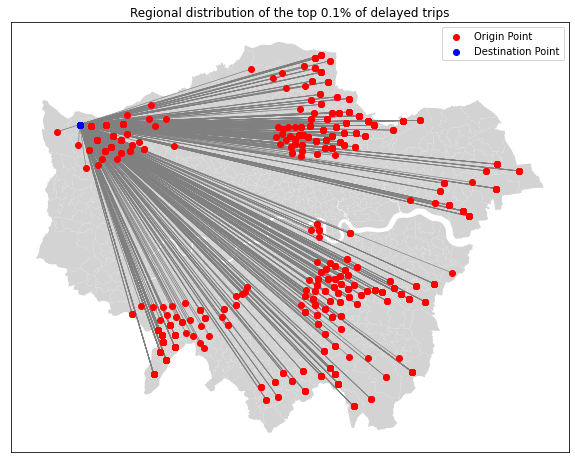

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
London.plot(ax=ax, color='lightgrey')
num = round(commute_rank.shape[0]*0.001)

for i in range(0,num):
    origin_point = London[London['MSOA11CD']==commute_rank.loc[i,'Origin_MSOACD']].reset_index(drop=True).loc[0,'centre'] 
    destination_point = London[London['MSOA11CD']==commute_rank.loc[0,'Destination_MSOACD']].reset_index(drop=True).loc[0,'centre'] 
    
    if i == 0:  # add label only for the first set of points
        ax.scatter(origin_point.x, origin_point.y, color='red', zorder=5, label='Origin Point')
        ax.scatter(destination_point.x, destination_point.y, color='blue', zorder=5, label='Destination Point')
    else:
        ax.scatter(origin_point.x, origin_point.y, color='red', zorder=5)
        ax.scatter(destination_point.x, destination_point.y, color='blue', zorder=5)
    
    line_width=commute_rank.loc[i, 'commute_time_difference_tube']/commute_rank['commute_time_difference_tube'].max()
    ax.plot([origin_point.x, destination_point.x], [origin_point.y, destination_point.y], color='grey', linewidth=line_width)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Regional distribution of the top 0.1% of delayed trips')
ax.legend()  # Display legend
plt.show()


In [81]:
pd.set_option('display.float_format', '{:.2f}'.format)
commute_time_com.describe()

,commute_time_usual,commute_time_strike_tube,commute_time_difference_tube
count,965970.00,965864.00,965864.00
mean,75.13,86.47,11.35
std,25.37,30.43,12.85
min,0.00,0.00,-1.00
25%,57.00,65.00,1.00
50%,74.00,85.00,7.00
75%,92.00,105.00,18.00
max,239.00,239.00,125.00


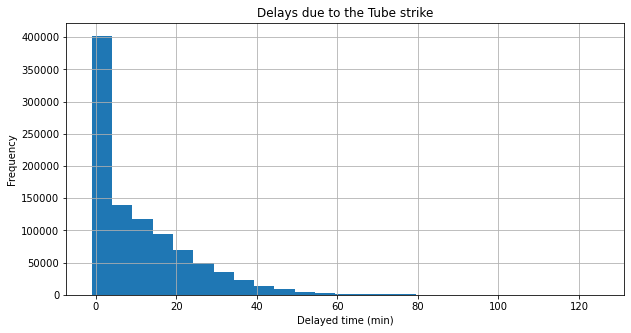

In [82]:
fig, ax = plt.subplots(figsize=(10,5))
commute_time_com['commute_time_difference_tube'].hist(bins=25, ax=ax)
ax.set_xlabel('Delayed time (min)')
ax.set_ylabel('Frequency')
ax.set_title('Delays due to the Tube strike')

#commute_time_com['commute_time_difference_tram'].hist(bins=25, ax=axes[1])
#axes[1].set_xlabel('Delayed time')
#axes[1].set_ylabel('Frequency')
#axes[1].set_title('Delays due to the Tram strike (min)')
plt.show()

## Spatial distribution of delays due to the strike

In [83]:
commute_time_strike_tube_mean=commute_time_com.groupby(by='Origin_MSOACD').mean()
commute_time_strike_tube_mean=commute_time_strike_tube_mean.loc[:,['commute_time_difference_tube']]
commute_time_strike_tube_mean=commute_time_strike_tube_mean.reset_index()
commute_time_strike_tube_des_mean=commute_time_com.groupby(by='Destination_MSOACD').mean()
commute_time_strike_tube_des_mean=commute_time_strike_tube_des_mean.loc[:,['commute_time_difference_tube']]
commute_time_strike_tube_des_mean=commute_time_strike_tube_des_mean.reset_index()
commute_time_strike_tube_mean.head()

,Origin_MSOACD,commute_time_difference_tube
0,E02000001,8.85
1,E02000002,6.86
2,E02000003,4.82
3,E02000004,9.85
4,E02000005,4.92


In [84]:
A=[-0.09213*np.pi/180.,51.51482*np.pi/180.] #Latitude of interest here 40.7 deg, longitude -74.5
B=[-1.09213*np.pi/180.,51.51482*np.pi/180.] ##Latitude of interest here 40.7 deg, longitude -74.5+1
dx=(6371000)*haversine_distances([A,B])[0,1]

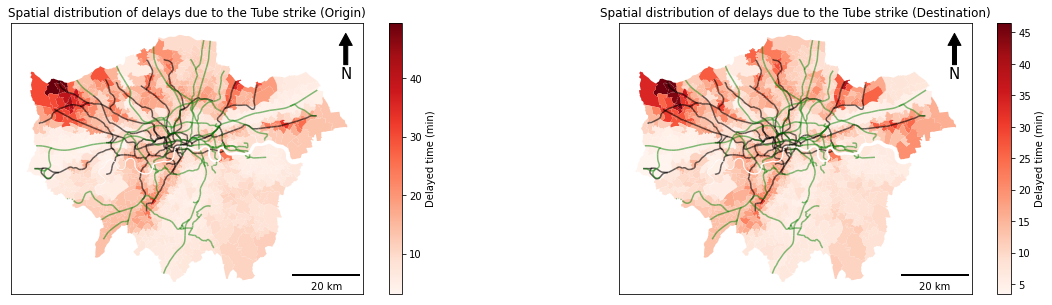

In [85]:
x, y, arrow_length = 0.95, 0.96, 0.15

commute_time_strike_tube_mean_geo=pd.merge(London, commute_time_strike_tube_mean, left_on='MSOA11CD', right_on='Origin_MSOACD')
commute_time_strike_tube_des_mean_geo=pd.merge(London, commute_time_strike_tube_des_mean, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)


#commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p25'], legend= True, cmap='Reds', ax=axes[0])
commute_time_strike_tube_mean_geo.plot(column=commute_time_strike_tube_mean_geo['commute_time_difference_tube'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
#lines.plot(color='black', alpha=0.4, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0])
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike (Origin)')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time (min)')


test=commute_time_strike_tube_mean_geo.plot(column=commute_time_strike_tube_des_mean_geo['commute_time_difference_tube'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1])
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike (Destination)')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time (min)')

## Consider the number of commuters

In [86]:
def collect_data(commuter_strategy):
    if list(commuter_strategy.columns) == ['Area of residence', 'Area of workplace','All categories: Age 16 and over', '16-24', '25-34', '35-49', '50-64', '65-74', '75+']:
        commuter_strategy = commuter_strategy.rename(columns={'Area of residence':'Area of usual residence'})
        
    commuter_strategy=commuter_strategy[commuter_strategy['Area of usual residence'].isin(London_MSOA_list)]
    commuter_strategy=commuter_strategy[commuter_strategy['Area of workplace'].isin(London_MSOA_list)]
    commuter_strategy=commuter_strategy.reset_index()
    
    columns_name=list(commuter_strategy.columns)[3:]
    
    commuter_strategy = pd.merge(commuter_strategy, London_MSOA, left_on=['Area of usual residence'], right_on=['MSOA11CD'])
    commuter_strategy=commuter_strategy.rename(columns={'MSOA11NM':'Residence_MSOANM'})
    commuter_strategy=commuter_strategy.drop(['MSOA11CD'], axis=1)
    
    commuter_strategy = pd.merge(commuter_strategy, London_MSOA, left_on=['Area of workplace'], right_on=['MSOA11CD'])
    commuter_strategy=commuter_strategy.rename(columns={'MSOA11NM':'Workplace_MSOANM'})
    commuter_strategy=commuter_strategy.drop(['MSOA11CD'], axis=1)
    
    order=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'] + columns_name
    commuter_strategy=commuter_strategy[order]
    
    return commuter_strategy

In [87]:
commuter_age=collect_data(commuter_age)
commuter_age_strike = pd.merge(commute_time_com, commuter_age, left_on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'], 
                        right_on=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'])

commuter_industry=collect_data(commuter_industry)
commuter_industry_strike = pd.merge(commute_time_com, commuter_industry, left_on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'], 
                        right_on=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'])

commuter_occupation=collect_data(commuter_occupation)
commuter_occupation_strike = pd.merge(commute_time_com, commuter_occupation, left_on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'], 
                        right_on=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'])

In [88]:
commuter_strike=commuter_age_strike.copy()
commuter_strike=commuter_strike[~(commuter_strike['Destination_MSOACD']==commuter_strike['Origin_MSOACD'])]

commuter_strike['Passenger_difference_tube']=commuter_strike['commute_time_difference_tube']*commuter_strike['All categories: Age 16 and over']
#commuter_strike['Passenger_difference_tram']=commuter_strike['commute_time_difference_tram']*commuter_strike['All categories: Age 16 and over']

commuter_strike=commuter_strike.rename(columns={'All categories: Age 16 and over':'Passenger_number'})

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM' ,'commute_time_difference_tube', #'commute_time_difference_tram', 
       'Passenger_number', 'Passenger_difference_tube']
commuter_strike=commuter_strike[order]
commuter_strike.describe()

,commute_time_difference_tube,Passenger_number,Passenger_difference_tube
count,351289.00,351292.00,351289.00
mean,8.24,7.97,54.49
std,10.35,24.62,319.58
min,-1.00,1.00,-5.00
25%,0.00,1.00,0.00
50%,4.00,2.00,8.00
75%,13.00,6.00,30.00
max,120.00,1867.00,24038.00


### Average

In [89]:
tube_strike_sum = commuter_strike['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

print(f'Average commuting delays for London commuters: {ave_tube_delay:.2f}')

Average commuting delays for London commuters: 6.84


In [90]:
commuter_strike_sum_origin=commuter_strike.groupby(by='Origin_MSOACD').sum()
#commuter_strike_tube_sum_origin=commuter_strike_tube_sum_origin.loc[:,['Passenger_difference_tube', 'Passenger_number']]
commuter_strike_sum_origin['average_difference_tube']=commuter_strike_sum_origin['Passenger_difference_tube']/commuter_strike_sum_origin['Passenger_number']
#commuter_strike_sum_origin['average_difference_tram']=commuter_strike_sum_origin['Passenger_difference_tram']/commuter_strike_sum_origin['Passenger_number']
commuter_strike_sum_origin=commuter_strike_sum_origin.loc[:,['average_difference_tube']]
commuter_strike_sum_origin=commuter_strike_sum_origin.reset_index(drop=False)

commuter_strike_sum_destination=commuter_strike.groupby(by='Destination_MSOACD').sum()
#commuter_strike_tube_sum_destination=commuter_strike_tube_sum_destination.reset_index(drop=False)
#commuter_strike_tube_sum_destination=commuter_strike_tube_sum_origin.loc[:,['Passenger_difference_tube', 'Passenger_number']]
commuter_strike_sum_destination['average_difference_tube']=commuter_strike_sum_destination['Passenger_difference_tube']/commuter_strike_sum_destination['Passenger_number']
#commuter_strike_sum_destination['average_difference_tram']=commuter_strike_sum_destination['Passenger_difference_tram']/commuter_strike_sum_destination['Passenger_number']
commuter_strike_sum_destination=commuter_strike_sum_destination.loc[:,['average_difference_tube']]
commuter_strike_sum_destination=commuter_strike_sum_destination.reset_index(drop=False)

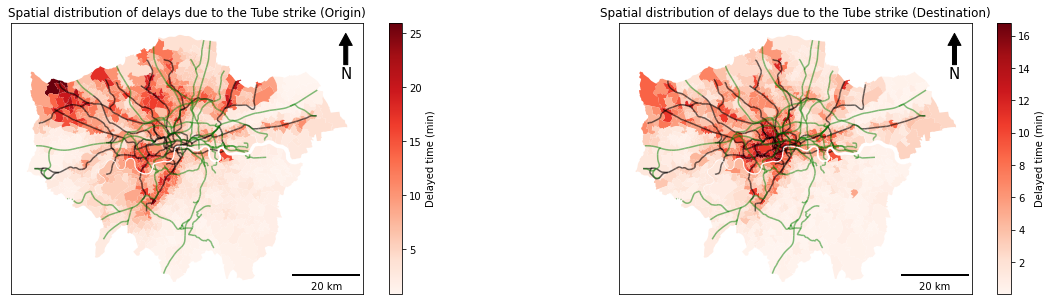

In [91]:
x, y, arrow_length = 0.95, 0.96, 0.15

commuter_strike_sum_origin_geo=pd.merge(London, commuter_strike_sum_origin, left_on='MSOA11CD', right_on='Origin_MSOACD')
commuter_strike_sum_destination_geo=pd.merge(London, commuter_strike_sum_destination, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)


#commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p25'], legend= True, cmap='Reds', ax=axes[0])
commuter_strike_sum_origin_geo.plot(column=commuter_strike_sum_origin['average_difference_tube'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
#lines.plot(color='black', alpha=0.4, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0])
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike (Origin)')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time (min)')


commuter_strike_sum_destination_geo.plot(column=commuter_strike_sum_destination_geo['average_difference_tube'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1])
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike (Destination)')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time (min)')

### Total

In [92]:
commuter_strike_mean_origin=commuter_strike.groupby(by='Origin_MSOACD').mean()
commuter_strike_mean_origin=commuter_strike_mean_origin.loc[:,['Passenger_difference_tube']]
commuter_strike_mean_origin=commuter_strike_mean_origin.reset_index(drop=False)

commuter_strike_mean_destination=commuter_strike.groupby(by='Destination_MSOACD').mean()
commuter_strike_mean_destination=commuter_strike_mean_destination.loc[:,['Passenger_difference_tube']]
commuter_strike_mean_destination=commuter_strike_mean_destination.reset_index(drop=False)

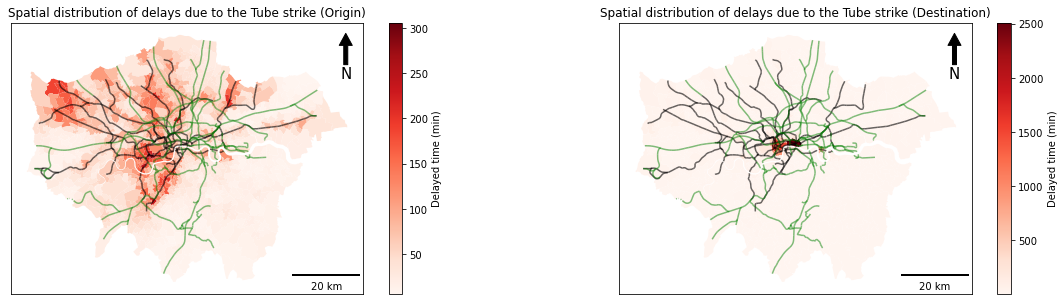

In [93]:
commuter_strike_mean_origin_geo=pd.merge(London, commuter_strike_mean_origin, left_on='MSOA11CD', right_on='Origin_MSOACD')
commuter_strike_mean_destination_geo=pd.merge(London, commuter_strike_mean_destination, left_on='MSOA11CD', right_on='Destination_MSOACD')


fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
commuter_strike_mean_origin_geo.plot(column=commuter_strike_mean_origin_geo['Passenger_difference_tube'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
#lines.plot(color='black', alpha=0.4, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0])
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike (Origin)')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time (min)')


commuter_strike_mean_destination_geo.plot(column=commuter_strike_mean_destination_geo['Passenger_difference_tube'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1])
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike (Destination)')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time (min)')

### Inner London and Outer London

In [94]:
inner_outer_London=gpd.read_file('./data/lp-falp-2006-inner-outer-london-shp/lp-falp-2006-inner-outer-london.shp')
central_london=gpd.read_file('./data/lp-falp-2006-central-activities-zone-shp/lp-falp-2006-central-activities-zone.shp')

In [95]:
central_london=central_london.to_crs(epsg=4326)

inner_london=inner_outer_London.iloc[[0],:]
inner_london=inner_london.to_crs(epsg=4326)
inner_london = gpd.overlay(inner_london, central_london, how='difference')

outer_london=inner_outer_London.iloc[[1],:]
outer_london=outer_london.to_crs(epsg=4326)

<AxesSubplot:>

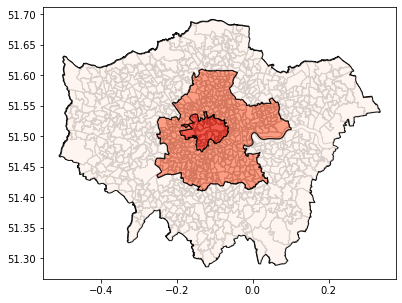

In [96]:
f,ax = plt.subplots(figsize=(10,5))
London.plot(facecolor='none', ax=ax)
central_london.plot(edgecolor='black', facecolor='#EE3D2E', linewidth=1, alpha=0.85, ax=ax)
inner_london.plot(edgecolor='black', facecolor='#FC8D6F', linewidth=1, alpha=0.85, ax=ax)
outer_london.plot(edgecolor='black', facecolor='#FFF4EE', linewidth=1, alpha=0.85, ax=ax)

In [97]:
central_london_bro = gpd.overlay( London, central_london,how='intersection')
central_london_bro=list(central_london_bro['MSOA11CD'])

inner_london_bro = gpd.overlay( London, inner_london,how='intersection')
inner_london_bro=list(inner_london_bro['MSOA11CD'])

outer_london_bro = gpd.overlay( London, outer_london,how='intersection')
outer_london_bro=list(outer_london_bro['MSOA11CD'])

In [98]:
commuter_strike_central_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(central_london_bro)]
#commuter_strike_central_origin=commuter_strike_central_origin.reset_index()


commuter_strike_cc=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_cc=commuter_strike_cc.reset_index().drop(['index'], axis=1)

commuter_strike_ci=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_ci=commuter_strike_ci.reset_index().drop(['index'], axis=1)

commuter_strike_co=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_co=commuter_strike_co.reset_index().drop(['index'], axis=1)

In [99]:
commuter_strike_inner_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(inner_london_bro)]
#commuter_strike_central_origin=commuter_strike_central_origin.reset_index()


commuter_strike_ic=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_ic=commuter_strike_ic.reset_index().drop(['index'], axis=1)

commuter_strike_ii=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_ii=commuter_strike_ii.reset_index().drop(['index'], axis=1)

commuter_strike_io=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_io=commuter_strike_io.reset_index().drop(['index'], axis=1)

In [100]:
commuter_strike_outer_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(outer_london_bro)]
#commuter_strike_central_origin=commuter_strike_central_origin.reset_index()


commuter_strike_oc=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_oc=commuter_strike_oc.reset_index().drop(['index'], axis=1)

commuter_strike_oi=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_oi=commuter_strike_oi.reset_index().drop(['index'], axis=1)

commuter_strike_oo=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_oo=commuter_strike_oo.reset_index().drop(['index'], axis=1)

In [101]:
delay_time_dict={}
delay_time_dict['origin_central']={}

tube_strike_sum = commuter_strike_cc['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_cc['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_central']['destination_central']=ave_tube_delay


tube_strike_sum = commuter_strike_ci['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_ci['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_central']['destination_inner']=ave_tube_delay


tube_strike_sum = commuter_strike_co['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_co['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_central']['destination_outer']=ave_tube_delay

In [102]:
delay_time_dict['origin_inner']={}

tube_strike_sum = commuter_strike_ic['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_ic['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_inner']['destination_central']=ave_tube_delay


tube_strike_sum = commuter_strike_ii['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_ii['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_inner']['destination_inner']=ave_tube_delay


tube_strike_sum = commuter_strike_io['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_io['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_inner']['destination_outer']=ave_tube_delay

In [103]:
delay_time_dict['origin_outer']={}

tube_strike_sum = commuter_strike_oc['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_oc['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_outer']['destination_central']=ave_tube_delay


tube_strike_sum = commuter_strike_oi['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_oi['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_outer']['destination_inner']=ave_tube_delay


tube_strike_sum = commuter_strike_oo['Passenger_difference_tube'].sum()
passenger_sum=commuter_strike_oo['Passenger_number'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_outer']['destination_outer']=ave_tube_delay

In [104]:
delay_time = pd.DataFrame(index=['origin_central', 'origin_inner', 'origin_outer'],
                       columns=['destination_central', 'destination_inner', 'destination_outer'])

london_area=['central', 'inner', 'outer']

for i in london_area:
    origin_area=f'origin_'+i
    for j in london_area:
        destination_area=f'destination_'+j
        
        delay_time.loc[origin_area, destination_area]=round(delay_time_dict[origin_area][destination_area],2)

delay_time

,destination_central,destination_inner,destination_outer
origin_central,8.20,7.44,9.53
origin_inner,10.87,6.15,4.80
origin_outer,11.13,7.51,2.33


In [105]:
commuter_zero = pd.merge(commuter_age, commute_time_com, right_on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'], 
                        left_on=['Area of usual residence', 'Residence_MSOANM', 'Area of workplace', 'Workplace_MSOANM'], how='right')
commuter_zero = commuter_zero.loc[:,['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM', 'All categories: Age 16 and over',
                                     'commute_time_usual', 'commute_time_strike_tube', 'commute_time_difference_tube']]
commuter_zero = commuter_zero[~(commuter_zero['All categories: Age 16 and over'].isna())]
commuter_zero.reset_index()

,index,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,All categories: Age 16 and over,commute_time_usual,commute_time_strike_tube,commute_time_difference_tube
0,0,E02000001,City of London 001,E02000001,City of London 001,1506.00,0.00,0.00,0.00
1,1,E02000002,Barking and Dagenham 001,E02000001,City of London 001,74.00,66.00,72.00,6.00
2,2,E02000003,Barking and Dagenham 002,E02000001,City of London 001,212.00,56.00,59.00,3.00
3,3,E02000004,Barking and Dagenham 003,E02000001,City of London 001,158.00,64.00,67.00,3.00
4,4,E02000005,Barking and Dagenham 004,E02000001,City of London 001,117.00,58.00,61.00,3.00
...,...,...,...,...,...,...,...,...,...
352270,965970,E02006927,Greenwich 034,E02006931,Greenwich 038,28.00,41.00,41.00,0.00
352271,965971,E02006928,Greenwich 035,E02006931,Greenwich 038,104.00,16.00,16.00,0.00
352272,965972,E02006929,Greenwich 036,E02006931,Greenwich 038,80.00,30.00,30.00,0.00
352273,965973,E02006930,Greenwich 037,E02006931,Greenwich 038,110.00,21.00,21.00,0.00


In [106]:
commuter_zero_count=commuter_zero.groupby('Origin_MSOACD').sum()
commuter_zero_count=commuter_zero_count.reset_index(drop=False)
commuter_zero_count=commuter_zero_count.loc[:,['Origin_MSOACD', 'All categories: Age 16 and over']]
#commuter_zero_count=commuter_zero_count.reset_index(drop=False)
commuters_sum=commuter_zero_count['All categories: Age 16 and over'].sum()
commuter_zero_count['Commuter_percentage']=commuter_zero_count['All categories: Age 16 and over']*100/commuter_zero_count['All categories: Age 16 and over'].sum()

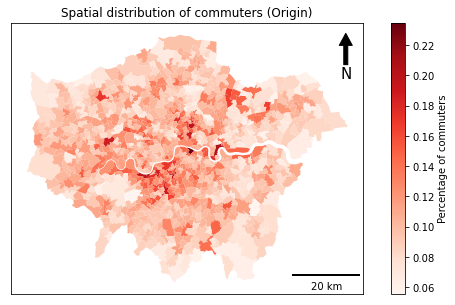

In [107]:
commuter_zero_geo=pd.merge(London, commuter_zero_count, left_on='MSOA11CD', right_on='Origin_MSOACD')

fig, ax = plt.subplots(figsize=(10,5))
commuter_zero_geo.plot(column=commuter_zero_geo['Commuter_percentage'], legend= False, cmap='Reds', alpha=1, ax=ax)
#lines.plot(color='black', alpha=0.4, ax=axes[0])
#clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0])
ax.set_xticks([])
ax.set_yticks([])
ax.add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
ax.set_title('Spatial distribution of commuters (Origin)')
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Percentage of commuters')

# GLM

In [108]:
stations = gpd.read_file('data/tfl_stations.json')
stations.head()

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry
0,940GZZLUACT,Acton Town,0500,"[ { ""name"": ""District"" }, { ""name"": ""Piccadill...",{'labelX': 30},None,1,None,3,POINT (-0.27992 51.50264)
1,940GZZLUACY,Archway,0508,"[ { ""name"": ""Northern"", ""nightopened"": 2016 } ]",{'labelX': -30},None,8,None,2/3,POINT (-0.13475 51.56537)
2,940GZZLUADE,Aldgate East,0503,"[ { ""name"": ""District"" }, { ""name"": ""Hammersmi...",{'labelX': 30},None,3,None,1,POINT (-0.07188 51.51515)
3,940GZZLUAGL,Angel,0507,"[ { ""name"": ""Northern"" }, { ""name"": ""Crossrail...","{'labelX': 1, 'labelY': -35}",None,7,None,1,POINT (-0.10613 51.53182)
4,940GZZLUALD,Aldgate,0502,"[ { ""name"": ""Circle"" }, { ""name"": ""Metropolita...","{'labelX': 25, 'labelY': 20}",None,2,None,1,POINT (-0.07572 51.51410)


In [109]:
stations = gpd.sjoin(stations, London, how="inner", op='within')
stations = stations.loc[:,['id', 'MSOA11CD', 'MSOA11NM', 'name', 'lines', 'zone', 'geometry']]
stations = stations.reset_index()

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [110]:
tube=['Bakerloo', 'Central', 'Circle', 'District', 'Hammersmith & City', 'Jubilee', 'Metropolitan', 'Northern', 'Piccadilly', 'Victoria', 'Waterloo & City']
station_tube=stations.loc[[0],:]
station_tram=stations.loc[[0],:]

for i in range(0, stations.shape[0]):
    stations_lines=json.loads(stations.loc[i,'lines'])
    
    for j in range(0,len(stations_lines)):
        if stations_lines[j]['name'] in tube:
            station_tube.loc[i]=stations.iloc[i,:]
            break
            
        else:
            station_tram.loc[i]=stations.iloc[i,:]


station_tram=station_tram.reset_index(drop=True)
station_tram=station_tram.drop(0)
station_tube=station_tube.reset_index(drop=True)
station_tube.head()

,index,id,MSOA11CD,MSOA11NM,name,lines,zone,geometry
0,0,940GZZLUACT,E02000270,Ealing 033,Acton Town,"[ { ""name"": ""District"" }, { ""name"": ""Piccadill...",3,POINT (-0.27992 51.50264)
1,1,940GZZLUACY,E02000557,Islington 004,Archway,"[ { ""name"": ""Northern"", ""nightopened"": 2016 } ]",2/3,POINT (-0.13475 51.56537)
2,2,940GZZLUADE,E02000884,Tower Hamlets 021,Aldgate East,"[ { ""name"": ""District"" }, { ""name"": ""Hammersmi...",1,POINT (-0.07188 51.51515)
3,3,940GZZLUAGL,E02000575,Islington 022,Angel,"[ { ""name"": ""Northern"" }, { ""name"": ""Crossrail...",1,POINT (-0.10613 51.53182)
4,78,940GZZLUFCN,E02000575,Islington 022,Farringdon,"[ { ""name"": ""Hammersmith & City"" }, { ""name"": ...",1,POINT (-0.10467 51.52021)


In [111]:
London_MSOA_cent['centre']=London_MSOA_cent.to_crs('+proj=cea').centroid.to_crs(epsg=27700)
London_MSOA_station=London_MSOA_cent.copy()

London_MSOA_cent=London_MSOA_cent.loc[:,['MSOA11CD', 'MSOA11NM', 'geometry', 'centre']]
London_MSOA_cent['distance_to_center'] = London_MSOA_cent.centre.apply(lambda point: point.distance(London_MSOA_cent[London_MSOA_cent['MSOA11CD']=='E02000001'].loc[0,'centre']))
London_MSOA_cent=London_MSOA_cent.loc[:,['MSOA11CD', 'distance_to_center']]
London_MSOA_cent.head()

,MSOA11CD,distance_to_center
0,E02000001,0.00
1,E02000002,18021.23
2,E02000003,17491.76
3,E02000004,19200.03
4,E02000005,17137.02


In [112]:
stations_distance=station_tram.copy()
stations_distance = stations_distance.set_crs("EPSG:4326")

# 现在，转换CRS到EPSG:27700
stations_distance = stations_distance.to_crs(epsg=27700)
stations_distance=stations_distance.loc[:,['geometry']]

London_MSOA_station['min_distance_station']=London_MSOA_station['MSOA11NM']

for i in range(0, London_MSOA_station.shape[0]):
    distances = stations_distance.geometry.apply(lambda stations_distance: London_MSOA_station.loc[i,'centre'].distance(stations_distance))
    min_distance = distances.min()
    London_MSOA_station.loc[i,'min_distance_station']=min_distance
    
    
London_MSOA_station['min_distance_station'] = London_MSOA_station['min_distance_station'].astype(float)
London_MSOA_station=London_MSOA_station.loc[:,['MSOA11CD', 'min_distance_station']]
London_MSOA_station.head()

,MSOA11CD,min_distance_station
0,E02000001,453.13
1,E02000002,2374.32
2,E02000003,1130.22
3,E02000004,2209.81
4,E02000005,1226.37


In [113]:
stations_tram_MSOA=station_tram.groupby('MSOA11CD').count()
stations_tram_MSOA=stations_tram_MSOA.reset_index(drop=False)
stations_tram_MSOA=stations_tram_MSOA.loc[:,['MSOA11CD', 'id']].rename(columns={'id':'number_of_tram_stations'})

stations_MSOA=station_tube.groupby('MSOA11CD').count()
stations_MSOA=stations_MSOA.reset_index(drop=False)
stations_MSOA=stations_MSOA.loc[:,['MSOA11CD', 'id']].rename(columns={'id':'number_of_tube_stations'})
stations_MSOA_geo=pd.merge(London, stations_MSOA, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
stations_MSOA_geo=stations_MSOA_geo.loc[:,['MSOA11CD', 'MSOA11NM', 'number_of_tube_stations', 'geometry']]
stations_MSOA_geo=pd.merge(stations_MSOA_geo, stations_tram_MSOA, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
stations_MSOA_geo=pd.merge(stations_MSOA_geo, London_MSOA_cent, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
stations_MSOA_geo=pd.merge(stations_MSOA_geo, London_MSOA_station, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
stations_MSOA_geo=pd.merge(stations_MSOA_geo, commute_time_strike_tube_mean, left_on='MSOA11CD', right_on='Origin_MSOACD', how='left')
stations_MSOA_geo=stations_MSOA_geo.replace(np.nan,0)

order=['commute_time_difference_tube', 'number_of_tube_stations', 'number_of_tram_stations', 'distance_to_center', 'min_distance_station']
stations_MSOA_geo=stations_MSOA_geo[order]
stations_MSOA_geo.head()

,commute_time_difference_tube,number_of_tube_stations,number_of_tram_stations,distance_to_center,min_distance_station
0,8.85,11.00,4.00,0.00,453.13
1,6.86,0.00,0.00,18021.23,2374.32
2,4.82,0.00,0.00,17491.76,1130.22
3,9.85,0.00,0.00,19200.03,2209.81
4,4.92,0.00,0.00,17137.02,1226.37


## VIF

In [116]:
def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

#         d = {'a': 1, 'b': 2, 'c': 3}
#  |  >>> ser = pd.Series(data=d, index=['a', 'b', 'c'])
#  |  >>> ser
#  |  a   1
#  |  b   2
#  |  c   3
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame() #  convert the given series object to a dataframe.

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [117]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor 
stations_MSOA_geo_VIF = drop_column_using_vif_(stations_MSOA_geo.drop('commute_time_difference_tube', axis=1))